In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import ProgressMeter
using Random

import Base: show
import PDMats: PDMat

┌ Info: Precompiling Rocket [df971d30-c9d6-4b37-b8ff-e965b2cb3a40]
└ @ Base loading.jl:1278
┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
import ReactiveMP: rule, marginalrule, score

function ReactiveMP.rule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:mean}}, 
        ::Marginalisation, 
        ::Nothing, 
        marginals::Tuple{Marginal,Marginal}, 
        ::Nothing)
    return NormalMeanVariance(mean(marginals[2]), mean(marginals[1]))
end

function ReactiveMP.rule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:value}}, 
        ::Marginalisation, 
        ::Nothing, 
        marginals::Tuple{Marginal, Marginal}, 
        ::Nothing)
    return NormalMeanVariance(mean(marginals[1]), mean(marginals[2]))
end

function ReactiveMP.marginalrule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:mean_variance_value}}, 
        messages::Tuple{Message{Float64},Message{Float64},Message{NormalMeanVariance{Float64}}}, 
        ::Nothing,
        ::Nothing)
    q_out = Message(NormalMeanVariance(getdata(messages[1]), getdata(messages[2]))) * messages[3]
    return (getdata(messages[1]), getdata(messages[2]), getdata(q_out))
end

function ReactiveMP.marginalrule(
        ::Type{NormalMeanVariance{Float64}}, 
        ::Type{Val{:mean_variance_value}}, 
        messages::Tuple{Message{NormalMeanVariance{Float64}},Message{Float64},Message{Float64}}, 
        ::Nothing,
        ::Nothing)
    q_mean = Message(NormalMeanVariance(getdata(messages[3]), getdata(messages[2]))) * messages[1]
    return (getdata(q_mean), getdata(messages[2]), getdata(messages[3]))
end

In [3]:
import LinearAlgebra: det

logmean(marginal::Marginal{Float64}) = log(getdata(marginal))
inversemean(marginal::Marginal{Float64}) = 1.0 / getdata(marginal)

function ReactiveMP.score(
        ::AverageEnergy, 
        ::Type{NormalMeanVariance{Float64}}, 
        marginals::Tuple{Marginal{Tuple{Float64,Float64,NormalMeanVariance{Float64}}}})
    factorised = map(as_marginal, getdata(marginals[1]))
    return score(AverageEnergy(), NormalMeanVariance{Float64}, factorised)
end

function ReactiveMP.score(
        ::AverageEnergy, 
        ::Type{NormalMeanVariance{Float64}}, 
        marginals::Tuple{Marginal{Tuple{NormalMeanVariance{Float64}, Float64,Float64}}})
    factorised = map(as_marginal, getdata(marginals[1]))
    return score(AverageEnergy(), NormalMeanVariance{Float64}, factorised)
end

function ReactiveMP.score(
        ::AverageEnergy, 
        ::Type{NormalMeanVariance{Float64}}, 
        marginals::Tuple{Marginal,Marginal,Marginal})
    
    m_mean, v_mean = mean(marginals[1]), var(marginals[1])
    m_out, v_out = mean(marginals[3]), var(marginals[3])

    0.5*log(2*pi) +
    0.5*logmean(marginals[2]) +
    0.5*inversemean(marginals[2])*(v_out + v_mean + (m_out - m_mean)^2)
end

function ReactiveMP.score(
        ::AverageEnergy,
        ::Type{GCV}, 
        marginals::Tuple{
            Marginal{MvNormalMeanCovariance{Float64}},
            Marginal{NormalMeanVariance{Float64}},
            Marginal{Float64},
            Marginal{Float64}
        })
    # m_out_x, cov_out_x = reverse(mean(marginals[1])), mirrormatrix(cov(marginals[1]))
    m_x_out, cov_x_out = mean(marginals[1]), cov(marginals[1])
    m_z, var_z = mean(marginals[2]), var(marginals[2])
    m_κ, var_κ = mean(marginals[3]), var(marginals[3])
    m_ω, var_ω = mean(marginals[4]), var(marginals[4])

    ksi = (m_κ^2)*var_z + (m_z^2)*var_κ + var_κ*var_z
    psi = (m_x_out[1]-m_x_out[2])^2 + cov_x_out[2,2]+cov_x_out[1,1]-cov_x_out[2,1]-cov_x_out[1,2]
    A = exp(-m_ω + var_ω/2)
    B = exp(-m_κ*m_z + ksi/2)

    return 0.5 * log(2pi) + 0.5 * (m_z*m_κ+m_ω) + 0.5 * (psi*A*B)
end

function ReactiveMP.score(::DifferentialEntropy, marginal::Marginal{ <: Tuple })
    return mapreduce((d) -> score(DifferentialEntropy(), as_marginal(d)), +, getdata(marginal), init = 0.0)
end

function ReactiveMP.score(::DifferentialEntropy, marginal::Marginal{Float64})
    return 0.0
end

function ReactiveMP.score(::DifferentialEntropy, marginal::Marginal{NormalMeanVariance{Float64}})
    return 0.5 * log(var(marginal)) + 0.5 * log(2pi) + 0.5
end

function ReactiveMP.score(::DifferentialEntropy, marginal::Marginal{MvNormalMeanCovariance{Float64}})
   dims = length(mean(marginal)) 
   return 0.5*log(det(cov(marginal))) + (dims / 2.0)*log(2pi) + (dims / 2.0) 
end

In [207]:
function hgf(n, iters, data, real_k, real_w, z_variance, y_variance)
    model = Model(DefaultMessageGate())
    
    xt_min_mean = add!(model, datavar(:xt_min_mean, Float64))
    xt_min_var  = add!(model, datavar(:xt_min_var, Float64))
    xt_min      = add!(model, randomvar(:xt_min))
    
    xt_min_prior = add!(model, make_node(NormalMeanVariance{Float64}, xt_min_mean, xt_min_var, xt_min))
    
    zt_min_mean = add!(model, datavar(:zt_min_mean, Float64))
    zt_min_var  = add!(model, datavar(:zt_min_var, Float64))
    zt_min      = add!(model, randomvar(:zt_min))
    
    zt_min_prior = add!(model, make_node(NormalMeanVariance{Float64}, zt_min_mean, zt_min_var, zt_min))
    
    zvar   = add!(model, constvar(:zvar, z_variance))
    zt     = add!(model, randomvar(:zt))
    
    z_transition = add!(model, make_node(NormalMeanVariance{Float64}, zt_min, zvar, zt, factorisation = ((1,),(2,),(3,))))
    
    xt = add!(model, randomvar(:xt))
    kt = add!(model, constvar(:kt, real_k))
    ωt = add!(model, constvar(:wt, real_w))
    
    gcv = add!(model, make_node(GCV, xt_min, zt, kt, ωt, xt))
    
    y_var = add!(model, constvar(:y_var, y_variance))
    y     = add!(model, datavar(:y, Float64))
    
    obs = add!(model, make_node(NormalMeanVariance{Float64}, xt, y_var, y))
    
    activate!(model)
    
    # Prior marginals
    
    ms_scheduler = PendingScheduler()
    fe_scheduler = PendingScheduler(false) # 
    fe = Vector{Float64}()    
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    mz = Vector{NormalMeanVariance}()
    tt = Vector{MvNormalMeanCovariance}()
    mx = Vector{NormalMeanVariance}()
    

    s_mz = subscribe!(getmarginal(zt) |> schedule_on(ms_scheduler), (t) -> push!(mz, getdata(t)))
    s_mx = subscribe!(getmarginal(xt) |> schedule_on(ms_scheduler), (t) -> push!(mx, getdata(t)))
    
    # Initial messages
    current_zt = NormalMeanVariance(0.0, 100.0)
    current_xt = NormalMeanVariance(0.0, 100.0)

    setmarginal!(gcv, :x_y, MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat([ 5.0 0.0 ; 0.0 5.0 ])))
    setmarginal!(gcv, :z, NormalMeanVariance(0.0, 5.0))
    # setmarginal!(z_transition, :mean, NormalMeanVariance(0.0, 5.0))
    # setmarginal!(z_transition, :value, NormalMeanVariance(0.0, 5.0))
    # setmarginal!(zt_min, current_zt)
    # setmarginal!(xt_min, current_xt)
    
    # foreach(_ -> push!(fe, 0.0), 1:4)
    
    # all_fe = Vector{Any}()
    
    ProgressMeter.@showprogress for i in 1:n
        
        for _ in 1:2
            update!(zt_min_mean, mean(current_zt))
            update!(zt_min_var, var(current_zt))
            update!(xt_min_mean, mean(current_xt))
            update!(xt_min_var, var(current_xt))
            update!(y, data[i])
        end
        
        for _ in 1:iters

            # update!(y, data[i])
            update!(zt_min_mean, mean(current_zt))
            # release!(fe_scheduler)
            update!(zt_min_var, var(current_zt))
            # release!(fe_scheduler)
            update!(xt_min_mean, mean(current_xt))
            # release!(fe_scheduler)
            update!(xt_min_var, var(current_xt))
            # release!(fe_scheduler)
            update!(y, data[i])
            release!(fe_scheduler)
        end
        
        release!(ms_scheduler)
        
        # push!(all_fe, copy(fe))
        # empty!(fe)
        
        current_zt = mz[end]
        current_xt = mx[end]
    end
    
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    unsubscribe!(fe_sub)
    
    # throw(1)
    
    # foreach(d -> pushfirst!(fe, first(fe)), 1:4)
    
    return mz, mx, fe
end

hgf (generic function with 1 method)

In [213]:
n = 1000
iters = 10

Random.seed!(223)

real_k = 0.1
real_w = 0.0

z_prev     = 0.0
z_variance = 1.5

z = Vector{Float64}(undef, n)
for i in 1:n
    z[i] = rand(Normal(z_prev, sqrt(z_variance)))
    z_prev = z[i]
end

# z = map(d -> 2.0 * sin(0.005 * d), 1:n)

v = map(d -> exp(real_k * d + real_w), z)

x_prev = 0.0

x = Vector{Float64}(undef, n)

for i in 1:n
    x[i] = rand(Normal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Float64}(undef, n)
y_variance = 1.0

for i in 1:n
    y[i] = rand(Normal(x[i], sqrt(y_variance)))
end

In [214]:
@time mz, mx, fe = hgf(n, iters, y, real_k, real_w, z_variance, y_variance);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.487326 seconds (4.97 M allocations: 246.125 MiB, 14.70% gc time)


In [215]:
# plot(fe[1:500])

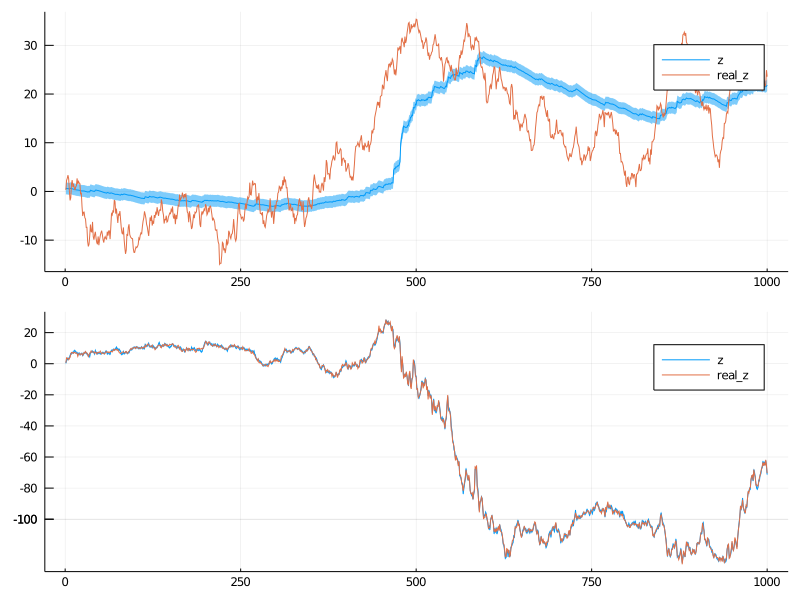

In [216]:
plot(mean.(mz), ribbon = std.(mz), label = :z)
p1 = plot!(z, label = :real_z)

plot(mean.(mx), ribbon = std.(mx), label = :z)
p2 = plot!(x, label = :real_z)

plot(p1, p2, layout = (2, 1), size = (800, 600))

# fevalues = reshape(fe, (iters, n))
# p3 = plot(sum(fevalues, dims = 2) / n)

# plot(p1, p2, p3, size = (1000, 600))

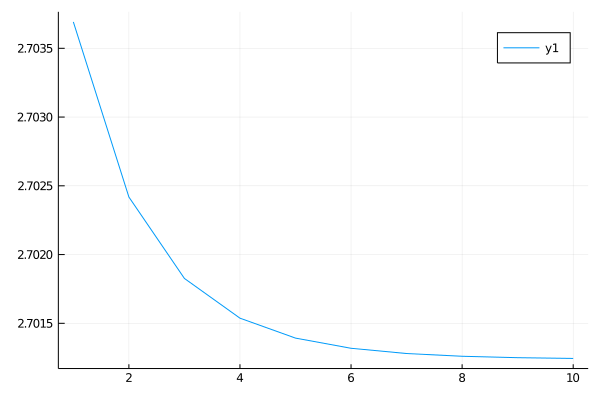

In [217]:
fevalues = reshape(fe, (iters, n))
p3 = plot(sum(fevalues[1:end, 1:end], dims = 2) / n)